In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
%reload_ext autoreload
%autoreload 2
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import gc
import warnings
from pathlib import Path
from tqdm.notebook import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

import pytorch_lightning as pl

import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import AdamW, get_cosine_schedule_with_warmup

import optim
import loss
from utils import visualize, radar2precipitation, seed_everything

<IPython.core.display.Javascript object>

In [4]:
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

In [5]:
args = dict(
    seed=42,
    dams=(6071, 6304, 7026, 7629, 7767, 8944, 11107),
    train_folds_csv=Path("../input/train_folds.csv"),
    train_data_path=Path("../input/train"),
    test_data_path=Path("../input/test"),
    model_dir=Path("../models"),
    output_dir=Path("../output"),
    rng=255.0,
    num_workers=4,
    gpus=1,
    lr=1e-3,
    max_epochs=50,
    batch_size=128,
    precision=16,
    optimizer="adamw",
    scheduler="cosine",
    accumulate_grad_batches=1,
    gradient_clip_val=5.0,
    warmup_epochs=1,
)

args["trn_tfms"] = A.Compose(
    [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, p=1),
        ToTensorV2(always_apply=True, p=1),
    ]
)

args["val_tfms"] = A.Compose(
    [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, p=1),
        ToTensorV2(always_apply=True, p=1),
    ]
)

<IPython.core.display.Javascript object>

# 🔥 RainNet ⚡️

## Dataset

In [6]:
class NowcastingDataset(Dataset):
    def __init__(self, paths, tfms=None, test=False):
        self.paths = paths
        if tfms is not None:
            self.tfms = tfms
        else:
            self.tfms = A.Compose(
                [
                    A.PadIfNeeded(
                        min_height=128, min_width=128, always_apply=True, p=1
                    ),
                    ToTensorV2(always_apply=True, p=1),
                ]
            )
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = np.load(path)

        augmented = self.tfms(image=data)
        data = augmented["image"]

        x = data[:4, :, :]
        x = x / args["rng"]
        if self.test:
            return x
        else:
            y = data[4, :, :]
            y = y / args["rng"]
            y = y.unsqueeze(0)
            return x, y

<IPython.core.display.Javascript object>

In [7]:
class NowcastingDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df=None,
        val_df=None,
        batch_size=args["batch_size"],
        num_workers=args["num_workers"],
        test=False,
    ):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.test = test

    def setup(self, stage="train"):
        if stage == "train":
            train_paths = [
                args["train_data_path"] / fn for fn in self.train_df.filename.values
            ]
            val_paths = [
                args["train_data_path"] / fn for fn in self.val_df.filename.values
            ]
            self.train_dataset = NowcastingDataset(train_paths, tfms=args["trn_tfms"])
            self.val_dataset = NowcastingDataset(val_paths, tfms=args["val_tfms"])
        else:
            test_paths = list(sorted(args["test_data_path"].glob("*.npy")))
            self.test_dataset = NowcastingDataset(test_paths, test=True)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=RandomSampler(self.train_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=2 * self.batch_size,
            sampler=SequentialSampler(self.val_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=2 * self.batch_size,
            sampler=SequentialSampler(self.test_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
        )

<IPython.core.display.Javascript object>

## RainNet

### Layers

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_ch),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        return self.net(x)


class Encoder(nn.Module):
    def __init__(self, chs=[4, 64, 128, 256, 512, 1024], drop_rate=0.5):
        super().__init__()
        self.blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #         self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, x):
        feats = []
        for block in self.blocks:
            x = block(x)
            feats.append(x)
            x = self.pool(x)
        return feats


class Decoder(nn.Module):
    def __init__(self, chs=[1024, 512, 256, 128, 64], bilinear=True):
        super().__init__()
        if bilinear:
            self.upsamples = nn.ModuleList(
                [
                    nn.Upsample(scale_factor=2, mode="nearest")
                    for i in range(len(chs) - 1)
                ]
            )
        else:
            self.upsamples = nn.ModuleList(
                [
                    nn.ConvTranspose2d(chs[i], chs[i], kernel_size=2, stride=2)
                    for i in range(len(chs) - 1)
                ]
            )
        self.blocks = nn.ModuleList(
            [Block(chs[i] + chs[i + 1], chs[i + 1]) for i in range(len(chs) - 1)]
        )

    def forward(self, x, feats):
        for upsample, block, feat in zip(self.upsamples, self.blocks, feats):
            #             print("Before upsample:", x.shape)
            x = upsample(x)
            #             print("After upsample:", x.shape)
            #             print("Feat:", feat.shape)
            x = torch.cat([feat, x], dim=1)
            #             print("Concat:", x.shape)
            x = block(x)
        #             print("After block:", x.shape)
        return x

<IPython.core.display.Javascript object>

### RainNet

In [9]:
class RainNet(pl.LightningModule):
    def __init__(
        self,
        lr=args["lr"],
        enc_chs=[4, 64, 128, 256, 512, 1024],
        dec_chs=[1024, 512, 256, 128, 64],
        num_train_steps=None,
        bilinear=True,
    ):
        super().__init__()
        self.lr = lr
        self.num_train_steps = num_train_steps
        #         self.criterion = loss.LogCoshLoss()
        self.criterion = nn.L1Loss()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs, bilinear=bilinear)
        self.out = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2),
            nn.Conv2d(2, 1, kernel_size=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        ftrs = self.encoder(x)
        ftrs = list(reversed(ftrs))
        x = self.decoder(ftrs[0], ftrs[1:])
        out = self.out(x)
        return out

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss, y, y_hat

    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self.shared_step(batch, batch_idx)
        self.log("train_loss", loss)
        for i, param_group in enumerate(self.optimizer.param_groups):
            self.log(f"lr/lr{i}", param_group["lr"])
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self.shared_step(batch, batch_idx)
        return {"loss": loss, "y": y.detach(), "y_hat": y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_loss", avg_loss)

        y = torch.cat([x["y"] for x in outputs])
        y_hat = torch.cat([x["y_hat"] for x in outputs])

        crop = T.CenterCrop(120)
        y = crop(y)
        y_hat = crop(y_hat)

        batch_size = len(y)

        y = y.detach().cpu().numpy()
        y = y.reshape(batch_size, -1)
        y = y[:, args["dams"]]
        y *= args["rng"]

        y_hat = y_hat.detach().cpu().numpy()
        y_hat = y_hat.reshape(batch_size, -1)
        y_hat = y_hat[:, args["dams"]]
        y_hat *= args["rng"]

        y_true = radar2precipitation(y)
        y_true = np.where(y_true >= 0.1, 1, 0)
        y_true = y_true.ravel()
        y_pred = radar2precipitation(y_hat)
        y_pred = np.where(y_pred >= 0.1, 1, 0)
        y_pred = y_pred.ravel()

        y = y.ravel()
        y_hat = y_hat.ravel()
        #         mae = metrics.mean_absolute_error(y, y_hat, sample_weight=y_true)

        err = (y - y_hat) * y_true
        err = np.abs(err)
        mae = err.sum() / y_true.sum()

        self.log("mae", mae)

        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        csi = tp / (tp + fn + fp)
        self.log("csi", csi)

        comp_metric = mae / (csi + 1e-12)
        self.log("comp_metric", comp_metric)

        print(
            f"Epoch {self.current_epoch} | MAE/CSI: {comp_metric} | MAE: {mae} | CSI: {csi} | Loss: {avg_loss}"
        )

    def configure_optimizers(self):
        # optimizer
        if args["optimizer"] == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "adamw":
            self.optimizer = AdamW(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "radam":
            self.optimizer = optim.RAdam(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "ranger":
            self.optimizer = optim.RAdam(self.parameters(), lr=self.lr)
            self.optimizer = optim.Lookahead(self.optimizer)

        # scheduler
        if args["scheduler"] == "cosine":
            self.scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=self.num_train_steps * args["warmup_epochs"],
                num_training_steps=self.num_train_steps * args["max_epochs"],
            )
            return [self.optimizer], [{"scheduler": self.scheduler, "interval": "step"}]
        elif args["scheduler"] == "step":
            self.scheduler = torch.optim.lr_scheduler.StepLR(
                self.optimizer, step_size=10, gamma=0.5
            )
            return [self.optimizer], [
                {"scheduler": self.scheduler, "interval": "epoch"}
            ]
        elif args["scheduler"] == "plateau":
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode="min", factor=0.1, patience=3, verbose=True
            )
            return [self.optimizer], [
                {
                    "scheduler": self.scheduler,
                    "interval": "epoch",
                    "reduce_on_plateau": True,
                    "monitor": "comp_metric",
                }
            ]
        else:
            self.scheduler = None
            return [self.optimizer]

<IPython.core.display.Javascript object>

## Train

In [10]:
seed_everything(args["seed"])
pl.seed_everything(args["seed"])

42

<IPython.core.display.Javascript object>

In [11]:
df = pd.read_csv(args["train_folds_csv"])

<IPython.core.display.Javascript object>

In [12]:
def train_fold(df, fold, lr_find=False, bilinear=False):
    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    datamodule = NowcastingDataModule(train_df, val_df)
    datamodule.setup()

    num_train_steps = np.ceil(
        len(train_df) // args["batch_size"] / args["accumulate_grad_batches"]
    )
    model = RainNet(num_train_steps=num_train_steps, bilinear=bilinear)

    trainer = pl.Trainer(
        gpus=args["gpus"],
        max_epochs=args["max_epochs"],
        precision=args["precision"],
        progress_bar_refresh_rate=50,
        benchmark=True,
    )

    if lr_find:
        lr_finder = trainer.tuner.lr_find(model, datamodule=datamodule)
        fig = lr_finder.plot(suggest=True)
        fig.show()
        return

    print(f"Training fold {fold}...")
    trainer.fit(model, datamodule)

    checkpoint = (
        args["model_dir"]
        / f"rainnet_fold{fold}_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{model.lr}_{args['optimizer']}_{args['scheduler']}.ckpt"
    )
    trainer.save_checkpoint(checkpoint)
    print("Model saved at", checkpoint)

    del model, trainer, datamodule
    gc.collect()
    torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Epoch 0 | MAE/CSI: 336.4057808053285 | MAE: 53.408172231985944 | CSI: 0.15876116071428573 | Loss: 0.598244309425354


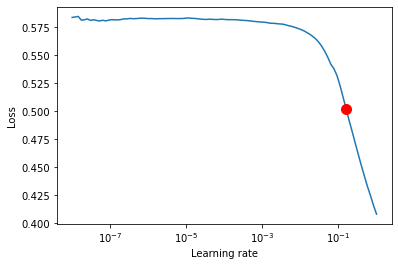

<IPython.core.display.Javascript object>

In [13]:
fold = 0
train_fold(df, fold, lr_find=True, bilinear=True)

In [ ]:
# AdamW bs128 lr 1e-3
for fold in range(5):
    train_fold(df, fold, bilinear=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Training fold 0...



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Epoch 0 | MAE/CSI: 336.4057808053285 | MAE: 53.408172231985944 | CSI: 0.15876116071428573 | Loss: 0.598244309425354


Epoch 0 | MAE/CSI: 851.2272794534249 | MAE: 140.2393953934741 | CSI: 0.16474964886307558 | Loss: 0.40799224376678467


Epoch 1 | MAE/CSI: 109.83946068802479 | MAE: 81.70424544145874 | CSI: 0.7438514804202483 | Loss: 0.1272396445274353


Epoch 2 | MAE/CSI: 75.52758898412003 | MAE: 58.209938219769676 | CSI: 0.770710928319624 | Loss: 0.0523519441485405


Epoch 3 | MAE/CSI: 23.392370284004784 | MAE: 18.79694412787908 | CSI: 0.8035502131525614 | Loss: 0.02864903211593628


Epoch 4 | MAE/CSI: 32.37117212343894 | MAE: 25.93985927003359 | CSI: 0.8013259195893926 | Loss: 0.023721566423773766


Epoch 5 | MAE/CSI: 26.157452161642333 | MAE: 20.989396349418186 | CSI: 0.8024251069900142 | Loss: 0.019010227173566818


Epoch 6 | MAE/CSI: 25.917166931877333 | MAE: 20.769555992082534 | CSI: 0.8013821899071342 | Loss: 0.017507778480648994


Epoch 7 | MAE/CSI: 38.251320729303224 | MAE: 30.751167638855566 | CSI: 0.8039243365330322 | Loss: 0.021157938987016678


Epoch 8 | MAE/CSI: 58.86530233760733 | MAE: 38.65860817819548 | CSI: 0.6567299689793448 | Loss: 0.021269183605909348


Epoch 9 | MAE/CSI: 41.746526641365925 | MAE: 31.07450567849538 | CSI: 0.7443614637789395 | Loss: 0.01815567910671234


Epoch 10 | MAE/CSI: 56.12451792683211 | MAE: 37.91385808728707 | CSI: 0.6755311134548742 | Loss: 0.020581135526299477


Epoch 11 | MAE/CSI: 25.1557488867044 | MAE: 20.33929562383787 | CSI: 0.8085346898403278 | Loss: 0.014991799369454384


Epoch 12 | MAE/CSI: 26.920995640834708 | MAE: 21.757567042608866 | CSI: 0.8082006822057988 | Loss: 0.015221461653709412


Epoch 13 | MAE/CSI: 23.155391641423765 | MAE: 18.816632869669206 | CSI: 0.812624254473161 | Loss: 0.013913542032241821


Epoch 14 | MAE/CSI: 21.637483453544107 | MAE: 17.401303753111506 | CSI: 0.8042203147353362 | Loss: 0.015407077968120575


Epoch 15 | MAE/CSI: 22.040701014232845 | MAE: 17.96442628007475 | CSI: 0.8150569380008436 | Loss: 0.01368167344480753


Epoch 16 | MAE/CSI: 22.008607869385187 | MAE: 17.85556759122237 | CSI: 0.8112992742279778 | Loss: 0.012915906496345997


Epoch 17 | MAE/CSI: 21.194299734786483 | MAE: 17.151350926492587 | CSI: 0.809243576862351 | Loss: 0.012440902180969715


Epoch 18 | MAE/CSI: 20.337474020254813 | MAE: 16.553419196482125 | CSI: 0.8139368330587983 | Loss: 0.012346466071903706


Epoch 19 | MAE/CSI: 20.196481001123846 | MAE: 16.48095607120565 | CSI: 0.8160310734463276 | Loss: 0.012524261139333248


Epoch 20 | MAE/CSI: 19.579376551711263 | MAE: 16.00924872048757 | CSI: 0.817658758346356 | Loss: 0.012212013825774193


Epoch 21 | MAE/CSI: 19.434638965829198 | MAE: 15.903576101936443 | CSI: 0.8183108587650816 | Loss: 0.012107722461223602


Epoch 22 | MAE/CSI: 19.315971947920712 | MAE: 15.801728971924296 | CSI: 0.8180654338549075 | Loss: 0.012064236216247082


Epoch 23 | MAE/CSI: 19.64415372044433 | MAE: 16.077096355533417 | CSI: 0.8184163382300251 | Loss: 0.011871688067913055


Epoch 24 | MAE/CSI: 18.46500519762341 | MAE: 15.164289529694248 | CSI: 0.8212448015789102 | Loss: 0.011801979504525661


Epoch 25 | MAE/CSI: 18.73391489637479 | MAE: 15.357639994264336 | CSI: 0.819777397260274 | Loss: 0.011744298972189426


Epoch 26 | MAE/CSI: 20.360283202755173 | MAE: 16.612902010809666 | CSI: 0.8159465094543101 | Loss: 0.011868265457451344


Epoch 27 | MAE/CSI: 18.691859697627716 | MAE: 15.343228950134394 | CSI: 0.8208508515641701 | Loss: 0.011681349016726017


Epoch 28 | MAE/CSI: 18.99759392298845 | MAE: 15.576239135507887 | CSI: 0.8199058890631684 | Loss: 0.011633138172328472


Epoch 29 | MAE/CSI: 18.369188522504103 | MAE: 15.073867430000524 | CSI: 0.8206060606060606 | Loss: 0.011501042172312737


Epoch 30 | MAE/CSI: 18.922362349209088 | MAE: 15.535369447206582 | CSI: 0.8210058110337901 | Loss: 0.011564943939447403


Epoch 31 | MAE/CSI: 19.756675427061698 | MAE: 16.16920061371377 | CSI: 0.8184170800086262 | Loss: 0.01166921854019165


Epoch 32 | MAE/CSI: 19.05487915631408 | MAE: 15.649650092243919 | CSI: 0.8212935891036155 | Loss: 0.011614903807640076


Epoch 33 | MAE/CSI: 22.18995794837799 | MAE: 18.11920549447614 | CSI: 0.8165497896213184 | Loss: 0.01295209489762783


Epoch 34 | MAE/CSI: 19.10433483456079 | MAE: 15.671032509831228 | CSI: 0.8202867383512544 | Loss: nan


Epoch 35 | MAE/CSI: 18.393898565887127 | MAE: 15.130253461079954 | CSI: 0.8225691474194469 | Loss: 0.011438152752816677


Epoch 36 | MAE/CSI: 18.77037865542701 | MAE: 15.43640507088513 | CSI: 0.8223811226313907 | Loss: nan


Epoch 37 | MAE/CSI: 18.248775363370108 | MAE: 15.022372152141783 | CSI: 0.823198918995804 | Loss: 0.011384990066289902


Epoch 38 | MAE/CSI: 18.63588369634031 | MAE: 15.310743075204217 | CSI: 0.8215732253250906 | Loss: nan


Epoch 39 | MAE/CSI: 18.42697808474478 | MAE: 15.136916292743354 | CSI: 0.8214540779888587 | Loss: 0.01135366503149271


Epoch 40 | MAE/CSI: 18.3887366130173 | MAE: 15.124588150346577 | CSI: 0.8224919671545876 | Loss: 0.01135934330523014


Epoch 41 | MAE/CSI: 18.447671622670043 | MAE: 15.157825857444367 | CSI: 0.8216660707901323 | Loss: 0.011356715112924576


Epoch 42 | MAE/CSI: 18.691355424587854 | MAE: 15.361878315052465 | CSI: 0.8218707507335575 | Loss: 0.011380273848772049


Epoch 43 | MAE/CSI: 18.04757378042738 | MAE: 14.87064560375836 | CSI: 0.8239692373424482 | Loss: 0.011337735690176487


Epoch 44 | MAE/CSI: 18.266029168429 | MAE: 15.038464900802056 | CSI: 0.8233023588277341 | Loss: 0.011326964013278484


Epoch 45 | MAE/CSI: 18.479300920181704 | MAE: 15.201695430997237 | CSI: 0.8226336860165856 | Loss: 0.011349148117005825


Epoch 46 | MAE/CSI: 18.199572864776194 | MAE: 14.979478572325606 | CSI: 0.82306758975091 | Loss: 0.011300484649837017


Epoch 47 | MAE/CSI: 18.323702636929 | MAE: 15.067870550759695 | CSI: 0.8223158195316962 | Loss: 0.011328000575304031


Epoch 48 | MAE/CSI: 18.407541280349236 | MAE: 15.14070985233944 | CSI: 0.8225275511664519 | Loss: 0.011321539990603924


Epoch 49 | MAE/CSI: 18.377727199363537 | MAE: 15.119684204570163 | CSI: 0.8227178497390807 | Loss: 0.011315426789224148

Model saved at ../models/rainnet_fold0_bs128_epochs50_lr0.001_adamw_cosine.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Training fold 1...


Epoch 0 | MAE/CSI: 379.5017715866807 | MAE: 48.814262472885034 | CSI: 0.12862723214285715 | Loss: 0.5731568932533264


Epoch 0 | MAE/CSI: 830.5491628719715 | MAE: 117.40163109142166 | CSI: 0.14135422240945475 | Loss: 0.34613731503486633


Epoch 1 | MAE/CSI: 91.81839230116013 | MAE: 73.22176802255336 | CSI: 0.797462972149387 | Loss: 0.11212663352489471


Epoch 2 | MAE/CSI: 27.0362165882638 | MAE: 21.741607933950867 | CSI: 0.8041660660227764 | Loss: 0.04682685807347298


Epoch 3 | MAE/CSI: 32.60717592544919 | MAE: 25.086674071184053 | CSI: 0.769360527526453 | Loss: 0.049210671335458755


Epoch 4 | MAE/CSI: 32.87824652390067 | MAE: 25.566604315596052 | CSI: 0.7776145938007266 | Loss: 0.028726404532790184


Epoch 5 | MAE/CSI: 190.37916632869667 | MAE: 106.61150056713778 | CSI: 0.5599956267424698 | Loss: 0.10083737224340439


Epoch 6 | MAE/CSI: 33.49095542174912 | MAE: 25.808580073012106 | CSI: 0.7706134312375708 | Loss: 0.02540106698870659


Epoch 7 | MAE/CSI: 27.259353606420433 | MAE: 21.691783022256423 | CSI: 0.7957555903717419 | Loss: 0.02527276985347271


Epoch 8 | MAE/CSI: 59.00217704973967 | MAE: 38.52305011603317 | CSI: 0.652908961028653 | Loss: 0.028482506051659584


Epoch 9 | MAE/CSI: 49.340782296089905 | MAE: 34.691828055656394 | CSI: 0.7031065670467951 | Loss: nan


Epoch 10 | MAE/CSI: 21.547635635406653 | MAE: 17.372861825157162 | CSI: 0.8062537402752843 | Loss: nan


Epoch 11 | MAE/CSI: 29.0514092954408 | MAE: 22.3223084614539 | CSI: 0.7683726539534182 | Loss: 0.023590411990880966


Epoch 12 | MAE/CSI: 37.202140917942096 | MAE: 28.288918404919073 | CSI: 0.7604110329908058 | Loss: 0.02394930273294449


Epoch 13 | MAE/CSI: 22.98714207860777 | MAE: 18.434432383002267 | CSI: 0.8019453797231575 | Loss: 0.020558180287480354


Epoch 14 | MAE/CSI: 23.26957075976557 | MAE: 18.73982572889693 | CSI: 0.8053361156655239 | Loss: 0.020575497299432755


Epoch 15 | MAE/CSI: 23.58595108606626 | MAE: 19.151916746031215 | CSI: 0.8120052770448549 | Loss: 0.021250629797577858


Epoch 16 | MAE/CSI: 20.393563470743203 | MAE: 16.54136147040107 | CSI: 0.8111069698099143 | Loss: 0.019684718921780586


Epoch 17 | MAE/CSI: 20.042915389054823 | MAE: 16.268009843645775 | CSI: 0.8116588593947506 | Loss: 0.019605526700615883


Epoch 18 | MAE/CSI: 22.412473170121277 | MAE: 18.109453748379607 | CSI: 0.8080078271995184 | Loss: 0.01997843012213707


Epoch 19 | MAE/CSI: 19.61756871954229 | MAE: 16.031871469031405 | CSI: 0.8172200999118425 | Loss: 0.019728684797883034


Epoch 20 | MAE/CSI: 19.732200014472237 | MAE: 16.09550881111185 | CSI: 0.8156976312467513 | Loss: 0.019471045583486557


Epoch 21 | MAE/CSI: 19.71513026073653 | MAE: 16.072754084463806 | CSI: 0.8152497027348394 | Loss: 0.01939563825726509


Epoch 22 | MAE/CSI: 19.210671393148324 | MAE: 15.676308675605446 | CSI: 0.8160208643815201 | Loss: 0.01918698474764824


Epoch 23 | MAE/CSI: 21.348405895212498 | MAE: 17.274073813627 | CSI: 0.8091505238561845 | Loss: 0.019472893327474594


Epoch 24 | MAE/CSI: 19.706948234670737 | MAE: 16.079432886548453 | CSI: 0.8159270880023906 | Loss: 0.01924729160964489


Epoch 25 | MAE/CSI: 34.29962118580521 | MAE: 27.4630366398738 | CSI: 0.800680464984406 | Loss: 0.02530735358595848


Epoch 26 | MAE/CSI: 19.79136074088518 | MAE: 16.115654821315218 | CSI: 0.8142772511848341 | Loss: 0.019455544650554657


Epoch 27 | MAE/CSI: 21.48409797192093 | MAE: 17.433473830543793 | CSI: 0.8114594270286486 | Loss: nan


Epoch 28 | MAE/CSI: 23.09111606533413 | MAE: 18.612775743463757 | CSI: 0.8060578661844484 | Loss: 0.019915243610739708


Epoch 29 | MAE/CSI: 19.490008098332357 | MAE: 15.914866592093816 | CSI: 0.8165654170988295 | Loss: 0.019278205931186676


Epoch 30 | MAE/CSI: 19.71195478626922 | MAE: 16.108600758104327 | CSI: 0.817199558985667 | Loss: 0.01950940676033497


Epoch 31 | MAE/CSI: 19.366664139296766 | MAE: 15.780887725744044 | CSI: 0.8148480095600866 | Loss: 0.018996911123394966


Epoch 32 | MAE/CSI: 20.004943414738534 | MAE: 16.282534976241763 | CSI: 0.8139255702280912 | Loss: 0.019085006788372993


Epoch 33 | MAE/CSI: 19.02802758919082 | MAE: 15.560641321557883 | CSI: 0.817774792925901 | Loss: 0.01893746294081211


Epoch 34 | MAE/CSI: 18.453699099554825 | MAE: 15.120410611002473 | CSI: 0.8193701723113488 | Loss: 0.018903637304902077


Epoch 35 | MAE/CSI: 18.984316961791034 | MAE: 15.549896907921621 | CSI: 0.8190917239318793 | Loss: 0.01895761489868164


Epoch 36 | MAE/CSI: 19.094590752430758 | MAE: 15.609456116165118 | CSI: 0.8174805272618334 | Loss: 0.01885439082980156


Epoch 37 | MAE/CSI: 18.80774036261592 | MAE: 15.40562411771875 | CSI: 0.8191108458899 | Loss: 0.01885846070945263


Epoch 38 | MAE/CSI: 18.277189251160205 | MAE: 14.992392518085383 | CSI: 0.8202788903723484 | Loss: 0.01883639022707939


Epoch 39 | MAE/CSI: 19.76735549674251 | MAE: 16.17491163422012 | CSI: 0.8182638105975197 | Loss: 0.018992852419614792


Epoch 40 | MAE/CSI: 18.058117511205 | MAE: 14.836280011266554 | CSI: 0.8215850850479091 | Loss: 0.018756549805402756


Epoch 41 | MAE/CSI: 18.178082741466547 | MAE: 14.930691238261979 | CSI: 0.821356765209621 | Loss: 0.018752722069621086


Epoch 42 | MAE/CSI: 18.276723836123214 | MAE: 15.012342504469848 | CSI: 0.8213913302547297 | Loss: 0.018736498430371284


Epoch 43 | MAE/CSI: 18.148915772713714 | MAE: 14.90182541084059 | CSI: 0.8210862619808307 | Loss: 0.0187591053545475


Epoch 44 | MAE/CSI: 18.212364304487497 | MAE: 14.959138487540471 | CSI: 0.8213726805276101 | Loss: 0.01873149909079075


Epoch 45 | MAE/CSI: 18.16989653471521 | MAE: 14.925030720065882 | CSI: 0.8214152838752884 | Loss: 0.018718460574746132


Epoch 46 | MAE/CSI: 18.20102030473038 | MAE: 14.954469055040585 | CSI: 0.8216280628584196 | Loss: 0.018718944862484932


Epoch 47 | MAE/CSI: 18.24522623158656 | MAE: 14.997007626100649 | CSI: 0.8219688501378642 | Loss: 0.018726889044046402


Epoch 48 | MAE/CSI: 18.17261528656933 | MAE: 14.937805814892833 | CSI: 0.8219953803740406 | Loss: 0.018716935068368912


Epoch 49 | MAE/CSI: 18.298108030165828 | MAE: 15.021140255814736 | CSI: 0.8209122074824862 | Loss: 0.018727868795394897

Model saved at ../models/rainnet_fold1_bs128_epochs50_lr0.001_adamw_cosine.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Training fold 2...


Epoch 0 | MAE/CSI: 270.7111357323698 | MAE: 43.05394736842105 | CSI: 0.15904017857142858 | Loss: 0.547532320022583


Epoch 0 | MAE/CSI: 824.3692924596616 | MAE: 120.68287881462305 | CSI: 0.14639419483192842 | Loss: 0.3203072249889374


Epoch 1 | MAE/CSI: 135.31623162772803 | MAE: 89.66539859868989 | CSI: 0.6626359418967221 | Loss: 0.08254968374967575


Epoch 2 | MAE/CSI: 45.54290021901838 | MAE: 35.04702791588217 | CSI: 0.7695387809580305 | Loss: 0.042056649923324585


Epoch 3 | MAE/CSI: 211.1032118978899 | MAE: 79.25169823965933 | CSI: 0.3754168282279953 | Loss: 0.041645802557468414


Epoch 4 | MAE/CSI: 36.437417082485744 | MAE: 28.170058166259707 | CSI: 0.7731079868381693 | Loss: 0.02194306254386902


Epoch 5 | MAE/CSI: 70.58472629909586 | MAE: 37.75884085164647 | CSI: 0.5349435045136606 | Loss: 0.03173857554793358


Epoch 6 | MAE/CSI: 27.881159411684454 | MAE: 22.233580963596825 | CSI: 0.7974410473852562 | Loss: 0.01828513666987419


Epoch 7 | MAE/CSI: 19.897511344503304 | MAE: 16.197337333048953 | CSI: 0.8140383514596451 | Loss: 0.01550195924937725


Epoch 8 | MAE/CSI: 27.829000981871314 | MAE: 21.86874469850749 | CSI: 0.7858257187430354 | Loss: 0.015892019495368004


Epoch 9 | MAE/CSI: 21.11183108889901 | MAE: 17.0924955879631 | CSI: 0.8096169165037295 | Loss: 0.013916689902544022


Epoch 10 | MAE/CSI: 24.223921772304422 | MAE: 19.547626823652134 | CSI: 0.806955496610669 | Loss: 0.014188835397362709


Epoch 11 | MAE/CSI: 20.32213817647545 | MAE: 16.51127657430578 | CSI: 0.8124773304316286 | Loss: 0.013155419379472733


Epoch 12 | MAE/CSI: 23.737533199970937 | MAE: 18.58459746541159 | CSI: 0.782920335859103 | Loss: 0.019955884665250778


Epoch 13 | MAE/CSI: 20.86632972141281 | MAE: 16.925578594319987 | CSI: 0.8111430625449317 | Loss: 0.012959692627191544


Epoch 14 | MAE/CSI: 19.70590377919541 | MAE: 16.090719803441804 | CSI: 0.8165431021950865 | Loss: 0.012357279658317566


Epoch 15 | MAE/CSI: 18.776920136624494 | MAE: 15.375098501007782 | CSI: 0.8188296264305766 | Loss: 0.01216345839202404


Epoch 16 | MAE/CSI: 18.964919271119133 | MAE: 15.55531227959926 | CSI: 0.8202150537634408 | Loss: 0.012243330478668213


Epoch 17 | MAE/CSI: 19.23431540066987 | MAE: 15.746667512549674 | CSI: 0.8186757461605332 | Loss: 0.011927510611712933


Epoch 18 | MAE/CSI: 18.291899073685013 | MAE: 15.020821213806396 | CSI: 0.8211734141589089 | Loss: 0.011770730838179588


Epoch 19 | MAE/CSI: 19.015175475346958 | MAE: 15.562383641408847 | CSI: 0.8184191443074692 | Loss: 0.011834865435957909


Epoch 20 | MAE/CSI: 20.120202830802185 | MAE: 16.424505128274667 | CSI: 0.8163190633004025 | Loss: 0.011988245882093906


Epoch 21 | MAE/CSI: 18.569269316572885 | MAE: 15.228230593765055 | CSI: 0.8200769957143895 | Loss: 0.01158822514116764


Epoch 22 | MAE/CSI: 18.248224809794063 | MAE: 15.025846310594067 | CSI: 0.8234141384816374 | Loss: 0.011551343835890293


Epoch 23 | MAE/CSI: 18.163714680331232 | MAE: 14.963916520001776 | CSI: 0.8238356956899046 | Loss: 0.011585965752601624


Epoch 24 | MAE/CSI: 18.350711779249217 | MAE: 15.083799712768469 | CSI: 0.8219735503560529 | Loss: 0.01150451134890318


Epoch 25 | MAE/CSI: 19.28657518492255 | MAE: 15.8863000370731 | CSI: 0.823697306791569 | Loss: 0.011653022840619087


Epoch 26 | MAE/CSI: 17.706335978747877 | MAE: 14.587489906120107 | CSI: 0.8238570601851852 | Loss: 0.011293087154626846


Epoch 27 | MAE/CSI: 18.59037858319951 | MAE: 15.264862740770212 | CSI: 0.8211162926260566 | Loss: 0.011432108469307423


Epoch 28 | MAE/CSI: 17.77012812064616 | MAE: 14.689610925741622 | CSI: 0.8266463148713475 | Loss: 0.011268140748143196


Epoch 29 | MAE/CSI: 18.248919756227128 | MAE: 15.08150958753038 | CSI: 0.8264330047462578 | Loss: 0.011347295716404915


Epoch 30 | MAE/CSI: 18.29934510727998 | MAE: 15.116966286163438 | CSI: 0.8260932944606414 | Loss: 0.011362237855792046


In [ ]:
seed_everything(args["seed"])
pl.seed_everything(args["seed"])

df = pd.read_csv(args["train_folds_csv"])

for fold in range(5):
    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    datamodule = NowcastingDataModule(
        train_df, val_df, batch_size=args["batch_size"], num_workers=args["num_workers"]
    )
    datamodule.setup()

    num_train_steps = (
        int(
            np.ceil(
                len(train_df) // args["batch_size"] / args["accumulate_grad_batches"]
            )
        )
        * args["max_epochs"]
    )

    model = RainNet(num_train_steps=num_train_steps)

    trainer = pl.Trainer(
        gpus=args["gpus"],
        max_epochs=args["max_epochs"],
        precision=args["precision"],
        progress_bar_refresh_rate=50,
        #         auto_lr_find=True,
#         benchmark=True,
    )

    # learning rate finder
    #     lr_finder = trainer.tuner.lr_find(model, datamodule=datamodule)
    #     fig = lr_finder.plot(suggest=True)
    #     fig.show()

    trainer.fit(model, datamodule)
    trainer.save_checkpoint(f"rainnet_fold{fold}_bs64_epoch50.ckpt")

    del datamodule, model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    break

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Epoch 0 | MAE/CSI: 44.72930992361908 | MAE: 7.238560199737549 | CSI: 0.16183035714285715 | Loss: 0.5618522763252258


../src/utils.py:36: RuntimeWarning: overflow encountered in power
  z = np.power(10.0, dbz / 10.0)


Epoch 0 | MAE/CSI: 3.380227101944409 | MAE: 2.691118001937866 | CSI: 0.7961352657004831 | Loss: 0.013766583986580372


Epoch 1 | MAE/CSI: 3.3351390941183854 | MAE: 2.668205976486206 | CSI: 0.8000283949740896 | Loss: 0.012434015050530434


Epoch 2 | MAE/CSI: 3.254171461657984 | MAE: 2.6064536571502686 | CSI: 0.8009576901086335 | Loss: 0.012150284834206104


Epoch 3 | MAE/CSI: 2.9932598900167617 | MAE: 2.4145052433013916 | CSI: 0.8066473784489451 | Loss: 0.012062947265803814


Epoch 4 | MAE/CSI: 3.2017156048262843 | MAE: 2.5828773975372314 | CSI: 0.8067166845301893 | Loss: 0.012147068046033382


../src/utils.py:36: RuntimeWarning: overflow encountered in power
  z = np.power(10.0, dbz / 10.0)


Epoch 5 | MAE/CSI: 3.101806781350983 | MAE: 2.5002763271331787 | CSI: 0.8060709461861093 | Loss: 0.012087756767868996


../src/utils.py:36: RuntimeWarning: overflow encountered in power
  z = np.power(10.0, dbz / 10.0)


Epoch 6 | MAE/CSI: 3.7159665055459423 | MAE: 2.9285545349121094 | CSI: 0.788100358422939 | Loss: 0.014243747107684612


Epoch 7 | MAE/CSI: 3.5832275825526168 | MAE: 2.8243930339813232 | CSI: 0.7882259691598213 | Loss: 0.012260997667908669


Epoch 8 | MAE/CSI: 4.340023416819759 | MAE: 3.3040218353271484 | CSI: 0.761291246152745 | Loss: 0.01332629844546318


../src/utils.py:36: RuntimeWarning: overflow encountered in power
  z = np.power(10.0, dbz / 10.0)


Epoch 9 | MAE/CSI: 8.132752788816978 | MAE: 5.300608158111572 | CSI: 0.6517606394469648 | Loss: 0.017829107120633125


## Inference

In [ ]:
def inference(checkpoints):
    datamodule = NowcastingDataModule()
    datamodule.setup("test")
    
    test_paths = datamodule.test_dataset.paths
    test_filenames = [path.name for path in test_paths]
    final_preds = np.zeros((len(datamodule.test_dataset), 14400))
    
    for checkpoint in checkpoints:
        print(f"Inference from {checkpoint}")
        model = RainNet.load_from_checkpoint(str(checkpoint))
        model.cuda()
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in tqdm(datamodule.test_dataloader()):
                batch = batch.cuda()
                imgs = model(batch)
                imgs = imgs.detach().cpu().numpy()
                imgs = imgs[:, 0, 4:124, 4:124]
                imgs = args["rng"] * imgs
                imgs = imgs.clip(0, 255)
                imgs = imgs.round()
                preds.append(imgs)
                
        preds = np.concatenate(preds)
        preds = preds.astype(np.uint8)
        preds = preds.reshape(-1, 14400)
        final_preds += preds / len(checkpoint)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()
        
    final_preds = final_preds.round()
    final_preds = final_preds.astype(np.uint8)
    
    subm = pd.DataFrame()
    subm["file_name"] = test_filename
    for i in tqdm(range(14400)):
        subm[str(i)] = final_preds[:, i]
        
    return subm

In [ ]:
checkpoints = [args["model_dir"] / f"rainnet_fold{fold}_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{model.lr}_{args['optimizer']}_{args['scheduler']}.ckpt" for fold in range(5)]
output_path = args["output_dir"] / f"rainnet_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{model.lr}_{args['optimizer']}_{args['scheduler']}.csv"
subm.to_csv(output_path, index=False)
subm.head()